In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 20.7 MB/s eta 0:00:00


In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 761.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 132.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.6 MB/s eta 0:00:00


In [4]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


modules loaded


In [5]:
plt.style.use('ggplot')
sns.set_palette("husl")

##Load the dataset

In [6]:
data_path = "/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/classification/Training"

images = []
labels = []
img_sizes = []
img_modes = []

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)

        with Image.open(image_path) as img:
            img_sizes.append(img.size)
            img_modes.append(img.mode)

        images.append(image_path)
        labels.append(subfolder)

data = pd.DataFrame({'image_path': images, 'label': labels, 'image_size': img_sizes, 'image_mode': img_modes})

Dataset information

Training set: {'notumor': 1595, 'meningioma': 1339, 'glioma': 1321, 'pituitary': 1457}
Testing set: {'pituitary': 300, 'notumor': 405, 'meningioma': 306, 'glioma': 300}


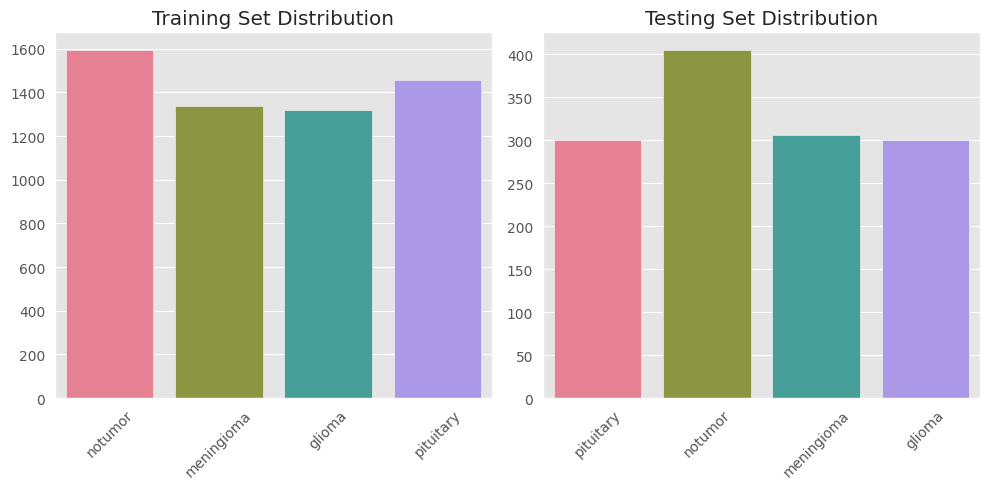

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from glob import glob
import cv2
import random

# Paths
base_dir = "/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/classification"
train_dir = os.path.join(base_dir, "/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/classification/Training")
test_dir = os.path.join(base_dir, "/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/classification/Testing")

# Function to count images in each class
def count_images(folder):
    counts = {}
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(glob(os.path.join(cls_path, "*.jpg"))) + \
                          len(glob(os.path.join(cls_path, "*.png"))) + \
                          len(glob(os.path.join(cls_path, "*.jpeg")))
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Training set:", train_counts)
print("Testing set:", test_counts)


plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette="husl")
plt.title("Training Set Distribution")
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), palette="husl")
plt.title("Testing Set Distribution")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



i have to add overview of testing dataset also

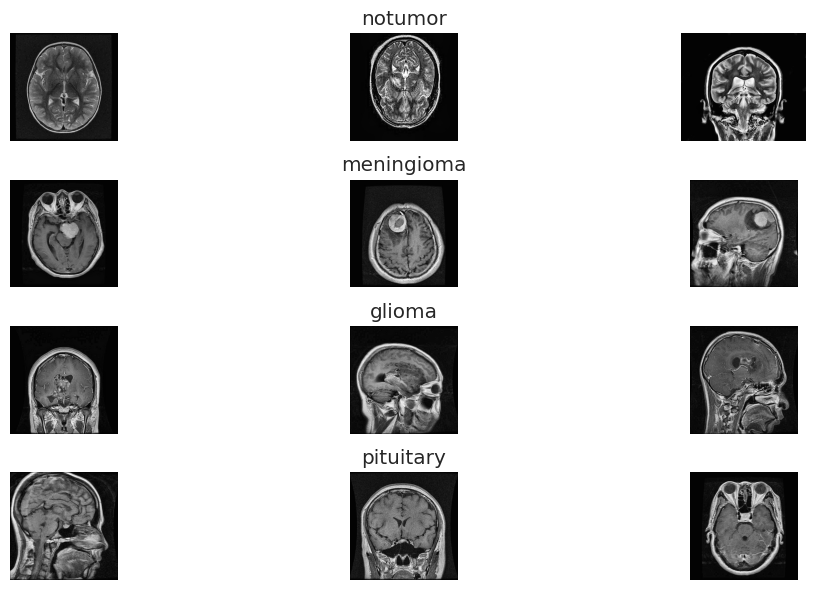

In [8]:

def show_random_images(folder, n=3):
    plt.figure(figsize=(12,6))
    classes = os.listdir(folder)
    for i, cls in enumerate(classes):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            imgs = glob(os.path.join(cls_path, "*"))
            for j in range(n):
                img_path = random.choice(imgs)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(len(classes), n, i*n + j + 1)
                plt.imshow(img)
                plt.axis("off")
                if j == 1:
                    plt.title(cls)
    plt.tight_layout()
    plt.show()

show_random_images(train_dir, n=3)

In [9]:
print("Dataset Overview:")
print(f"Total images: {len(data)}")
print(f"Classes: {data['label'].unique()}")
print(f"Class distribution:\n{data['label'].value_counts()}")
print(f"Image modes: {data['image_mode'].value_counts()}")
print(f"Unique image sizes: {data['image_size'].value_counts().head(5)}")

Dataset Overview:
Total images: 5712
Classes: ['notumor' 'meningioma' 'glioma' 'pituitary']
Class distribution:
label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
Image modes: image_mode
L    5712
Name: count, dtype: int64
Unique image sizes: image_size
(512, 512)    3955
(225, 225)     268
(630, 630)      77
(236, 236)      53
(201, 251)      43
Name: count, dtype: int64


In [10]:
def display_sample_images(data):
    sampled_data = data.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle('Sample Brain MRI Images (1 per class)', fontsize=16, fontweight='bold')

    for idx, (_, row) in enumerate(sampled_data.iterrows()):
        ax = axes[idx // 2, idx % 2]
        img = Image.open(row['image_path'])
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Class: {row['label']}\nSize: {img.size}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

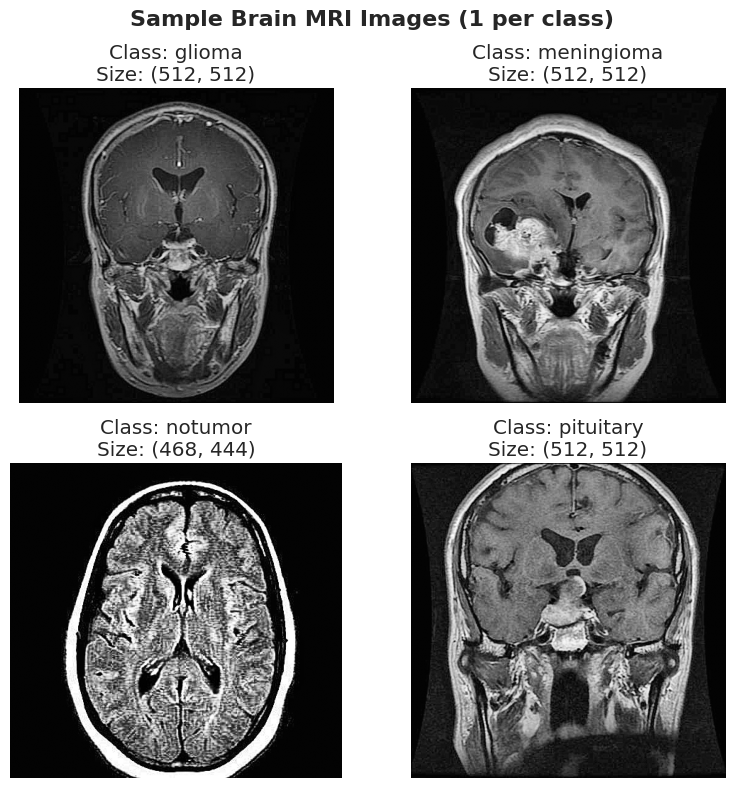

In [11]:
display_sample_images(data)

Image size distribution

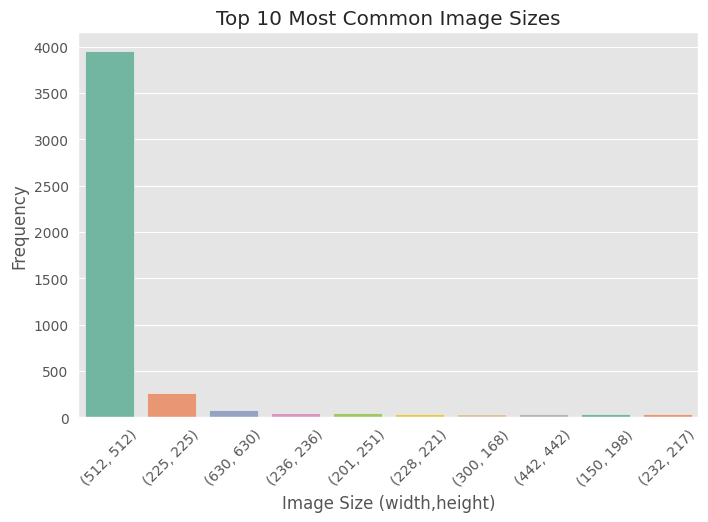

In [12]:

plt.figure(figsize=(8,5))
top_sizes = data['image_size'].value_counts().head(10)
sns.barplot(x=top_sizes.index.astype(str), y=top_sizes.values, palette="Set2")
plt.title("Top 10 Most Common Image Sizes")
plt.xlabel("Image Size (width,height)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

##class distribution

In [13]:
def plot_class_distribution(data):
    plt.figure(figsize=(10, 6))
    counts = data['label'].value_counts()
    colors = plt.cm.Set3(np.arange(len(counts)))
    plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title('Class Distribution in Dataset', fontweight='bold')
    plt.axis('equal')
    plt.show()

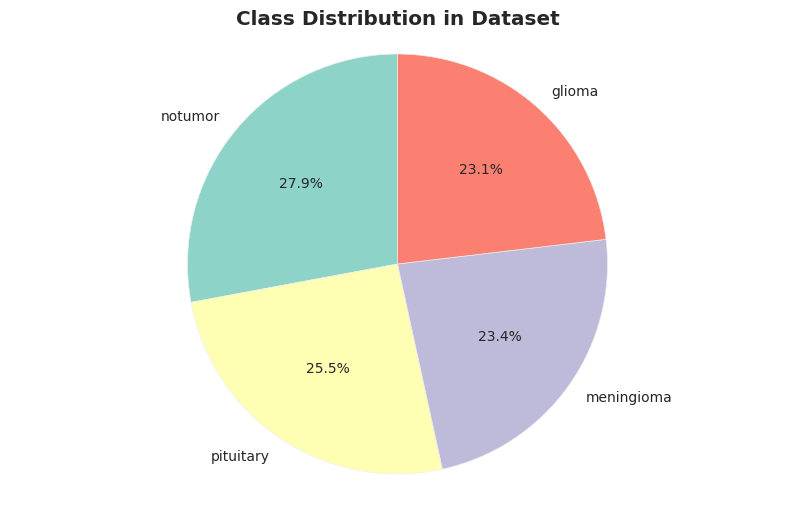

In [14]:
plot_class_distribution(data)

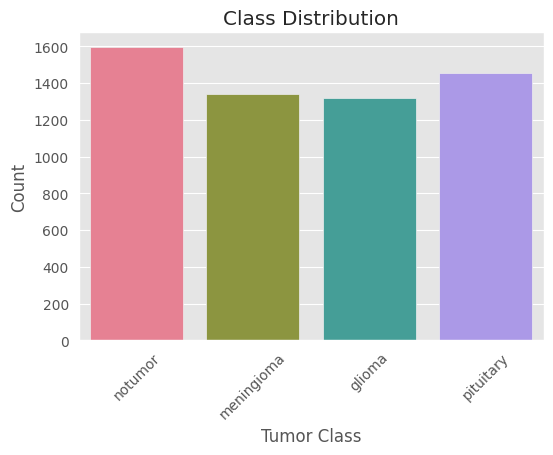

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(6,4))
sns.countplot(data=data, x="label", palette="husl")
plt.title("Class Distribution")
plt.xlabel("Tumor Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

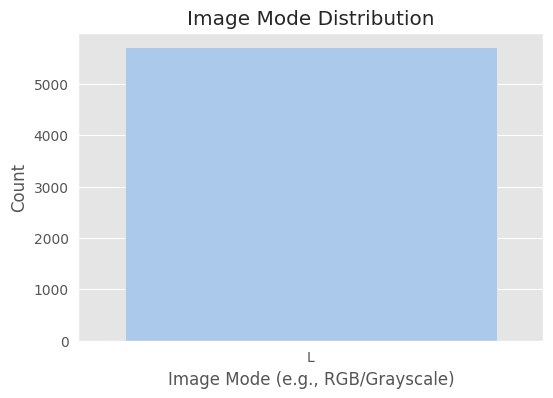

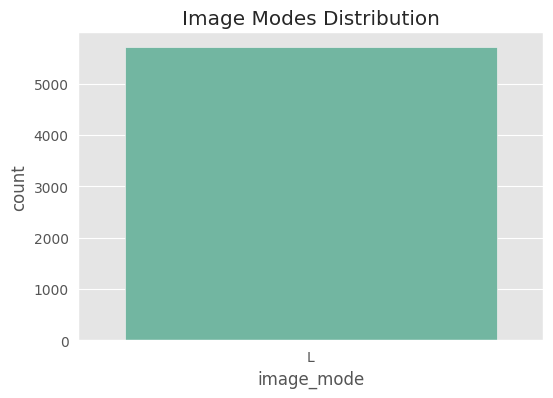

In [16]:



plt.figure(figsize=(6,4))
sns.countplot(data=data, x="image_mode", palette="pastel")
plt.title("Image Mode Distribution")
plt.xlabel("Image Mode (e.g., RGB/Grayscale)")
plt.ylabel("Count")
plt.show()


plt.figure(figsize=(6,4))
sns.countplot(x="image_mode", data=data, palette="Set2")
plt.title("Image Modes Distribution")
plt.show()

Image augmentation examples

In [17]:
def display_augmentation_examples(data):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Image Augmentation Examples', fontsize=16, fontweight='bold')

    sample_img_path = data.iloc[0]['image_path']
    img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)

    axes[0, 0].imshow(img, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    flipped = cv2.flip(img, 1)
    axes[0, 1].imshow(flipped, cmap='gray')
    axes[0, 1].set_title('Horizontal Flip')
    axes[0, 1].axis('off')

    rows, cols = img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1)
    rotated = cv2.warpAffine(img, M, (cols, rows))
    axes[0, 2].imshow(rotated, cmap='gray')
    axes[0, 2].set_title('Rotation (15°)')
    axes[0, 2].axis('off')


    rows, cols = img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 90, 1)
    rotated = cv2.warpAffine(img, M, (cols, rows))
    axes[0, 2].imshow(rotated, cmap='gray')
    axes[0, 2].set_title('Rotation (90°)')
    axes[0, 2].axis('off')


    bright = np.clip(img.astype(np.float32) + 30, 0, 255).astype(np.uint8)
    axes[0, 3].imshow(bright, cmap='gray')
    axes[0, 3].set_title('Increased Brightness')
    axes[0, 3].axis('off')

    contrast = np.clip(img.astype(np.float32) * 1.3, 0, 255).astype(np.uint8)
    axes[1, 0].imshow(contrast, cmap='gray')
    axes[1, 0].set_title('Increased Contrast')
    axes[1, 0].axis('off')

    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    axes[1, 1].imshow(blurred, cmap='gray')
    axes[1, 1].set_title('Gaussian Blur')
    axes[1, 1].axis('off')

    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(img, -1, kernel)
    axes[1, 2].imshow(sharpened, cmap='gray')
    axes[1, 2].set_title('Sharpened')
    axes[1, 2].axis('off')

    equalized = cv2.equalizeHist(img)
    axes[1, 3].imshow(equalized, cmap='gray')
    axes[1, 3].set_title('Histogram Equalization')
    axes[1, 3].axis('off')

    plt.tight_layout()
    plt.show()

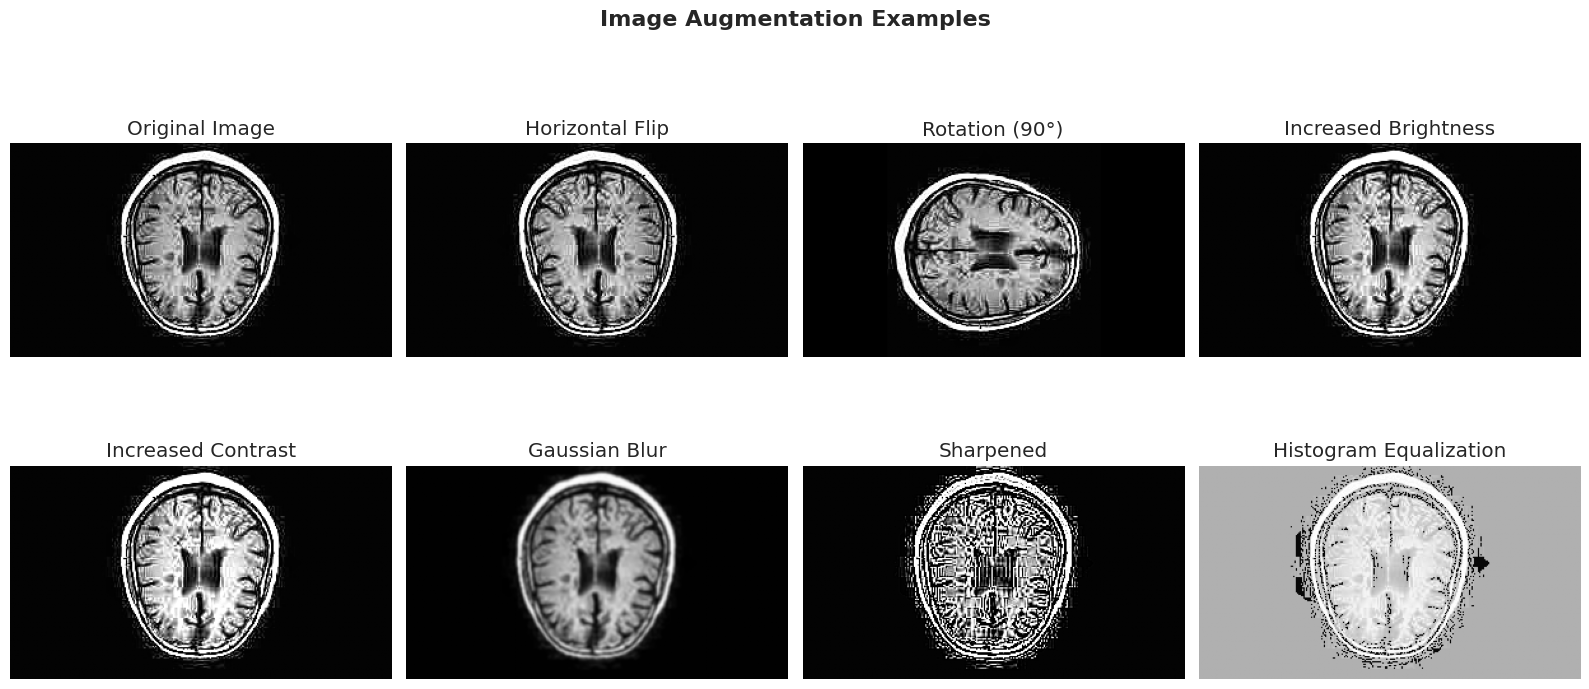

In [18]:
display_augmentation_examples(data)

Intensity distributions

In [19]:
def display_intensity_distributions(data):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Pixel Intensity Distributions by Class', fontsize=16, fontweight='bold')

    classes = data['label'].unique()

    for i, class_name in enumerate(classes):
        class_images = data[data['label'] == class_name]['image_path'].sample(min(5, len(data[data['label'] == class_name])))

        all_pixels = []
        for img_path in class_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            all_pixels.extend(img.flatten())

        ax = axes[i // 2, i % 2]
        ax.hist(all_pixels, bins=50, color=plt.cm.Set1(i), alpha=0.7)
        ax.set_title(f'Class: {class_name}')
        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
        ax.set_xlim(0, 255)

    plt.tight_layout()
    plt.show()

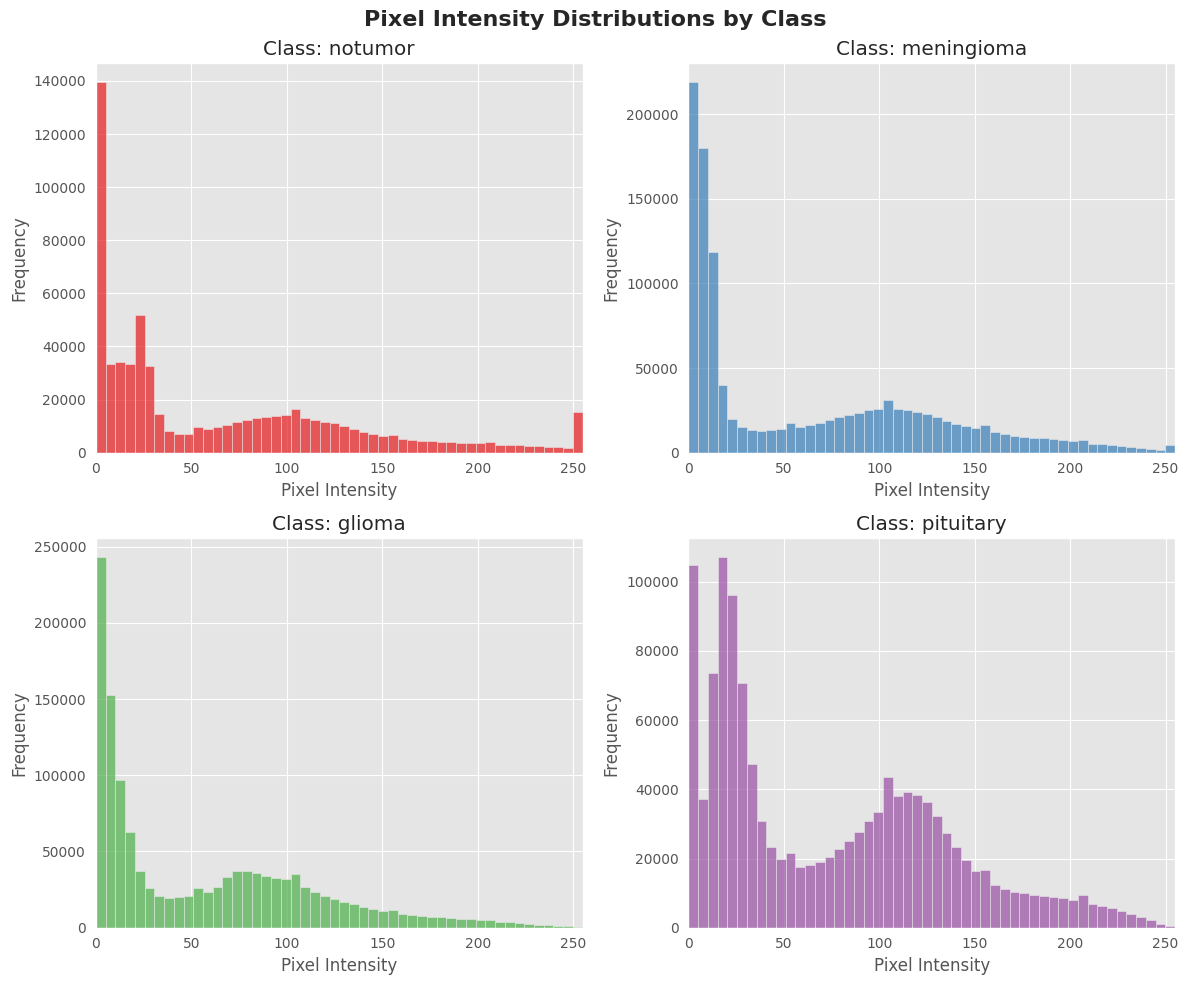

In [20]:
display_intensity_distributions(data)

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc,
                             precision_recall_curve, average_precision_score,
                             roc_auc_score, cohen_kappa_score, matthews_corrcoef,
                             log_loss, balanced_accuracy_score, jaccard_score,
                             hamming_loss, zero_one_loss)
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                    Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [24]:
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = "/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/classification/Training"
test_dir = "/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/classification/Testing"
IMAGE_SIZE = 224
batch_size = 20
epochs = 10

# ----------------------------
# Data Generators
# ----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # take 20% of train_dir for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode="sparse",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode="sparse",
    subset="validation"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=False
)

# ----------------------------
# Build VGG16 Model
# ----------------------------
base_model = VGG16(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
# Freeze all layers except the last 7
for layer in base_model.layers[:-7]:
    layer.trainable = False

# Unfreeze the last 7 layers
for layer in base_model.layers[-7:]:
    layer.trainable = True

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation="softmax")  # auto-detects classes
])

# ----------------------------
# Compile Model
# ----------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

# ----------------------------
# Train Model
# ----------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

# ----------------------------
# Evaluate on Test Set
# ----------------------------
test_loss, test_acc = model.evaluate(test_generator)
print(f" Test Accuracy: {test_acc*100:.2f}%")

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - loss: 0.7923 - sparse_categorical_accuracy: 0.6790 - val_loss: 0.6083 - val_sparse_categorical_accuracy: 0.7774
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - loss: 0.3101 - sparse_categorical_accuracy: 0.8867 - val_loss: 0.6177 - val_sparse_categorical_accuracy: 0.8002
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - loss: 0.2537 - sparse_categorical_accuracy: 0.9115 - val_loss: 0.3837 - val_sparse_categorical_accuracy: 0.8869
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - loss: 0.1994 - sparse_categorical_accuracy: 0.9292 - val_loss: 0.6416 - val_sparse_categorical_accuracy: 0.8133
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - loss: 0.2056 - sparse_categorical_accuracy: 0.9310 - val_loss: 0.5500 - val_sparse_categorical_accur

In [25]:
# Save the entire model to an H5 file
model.save('/content/vgg16_brain_tumor_classification_model_freeze_layer_7.keras')

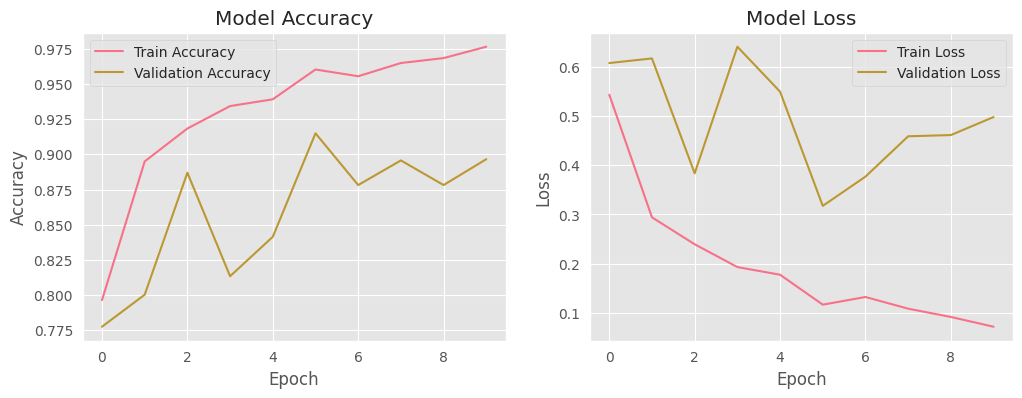

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss over epochs
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
import numpy as np
import cv2
import glob
import os

# Path to your test dataset folder
test_dir = "/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/classification/Testing"

# Load all test image paths
test_paths = glob.glob(test_dir + "/*/*.jpg")  # change to .png if needed
test_labels = [os.path.basename(os.path.dirname(path)) for path in test_paths]

# Convert labels to numeric
class_names = sorted(os.listdir(train_dir))  # same classes as training
label_to_index = {name: idx for idx, name in enumerate(class_names)}
test_labels = [label_to_index[label] for label in test_labels]

# Preprocess test images
IMAGE_SIZE = 224
X_test = []
for path in test_paths:
    img = cv2.imread(path)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img / 255.0  # normalize
    X_test.append(img)

X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(test_labels, dtype=np.int32)

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Now evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.1541 - sparse_categorical_accuracy: 0.9727
Test Accuracy: 0.9519
Test Loss: 0.2141


In [28]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, matthews_corrcoef,
    balanced_accuracy_score, jaccard_score,
    hamming_loss, zero_one_loss
)

metrics = {}

metrics['Accuracy'] = accuracy_score(y_test, y_pred)
metrics['Precision (Macro)'] = precision_score(y_test, y_pred, average='macro')
metrics['Recall (Macro)'] = recall_score(y_test, y_pred, average='macro')
metrics['F1-Score (Macro)'] = f1_score(y_test, y_pred, average='macro')
metrics['Precision (Micro)'] = precision_score(y_test, y_pred, average='micro')
metrics['Recall (Micro)'] = recall_score(y_test, y_pred, average='micro')
metrics['F1-Score (Micro)'] = f1_score(y_test, y_pred, average='micro')
metrics['Precision (Weighted)'] = precision_score(y_test, y_pred, average='weighted')
metrics['Recall (Weighted)'] = recall_score(y_test, y_pred, average='weighted')
metrics['F1-Score (Weighted)'] = f1_score(y_test, y_pred, average='weighted')

metrics['Cohen Kappa Score'] = cohen_kappa_score(y_test, y_pred)
metrics['Matthews Correlation Coefficient'] = matthews_corrcoef(y_test, y_pred)
metrics['Balanced Accuracy'] = balanced_accuracy_score(y_test, y_pred)
metrics['Jaccard Score (Macro)'] = jaccard_score(y_test, y_pred, average='macro')
metrics['Hamming Loss'] = hamming_loss(y_test, y_pred)
metrics['Zero-One Loss'] = zero_one_loss(y_test, y_pred)

# Display metrics nicely
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

Accuracy: 0.9519
Precision (Macro): 0.9506
Recall (Macro): 0.9506
F1-Score (Macro): 0.9492
Precision (Micro): 0.9519
Recall (Micro): 0.9519
F1-Score (Micro): 0.9519
Precision (Weighted): 0.9537
Recall (Weighted): 0.9519
F1-Score (Weighted): 0.9515
Cohen Kappa Score: 0.9356
Matthews Correlation Coefficient: 0.9363
Balanced Accuracy: 0.9506
Jaccard Score (Macro): 0.9045
Hamming Loss: 0.0481
Zero-One Loss: 0.0481


In [29]:
from tensorflow.keras.utils import to_categorical

# Number of classes (same as training)
num_classes = len(class_names)

# Convert true labels to one-hot encoding
y_test_bin = to_categorical(y_test, num_classes=num_classes)

roc_auc_scores = []


In [30]:


print("y_pred_probs shape:", y_pred_proba.shape)
# Example: compute ROC AUC score for each class
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro')
print("ROC AUC Score:", roc_auc)


y_pred_probs shape: (1311, 4)
ROC AUC Score: 0.994714393256962


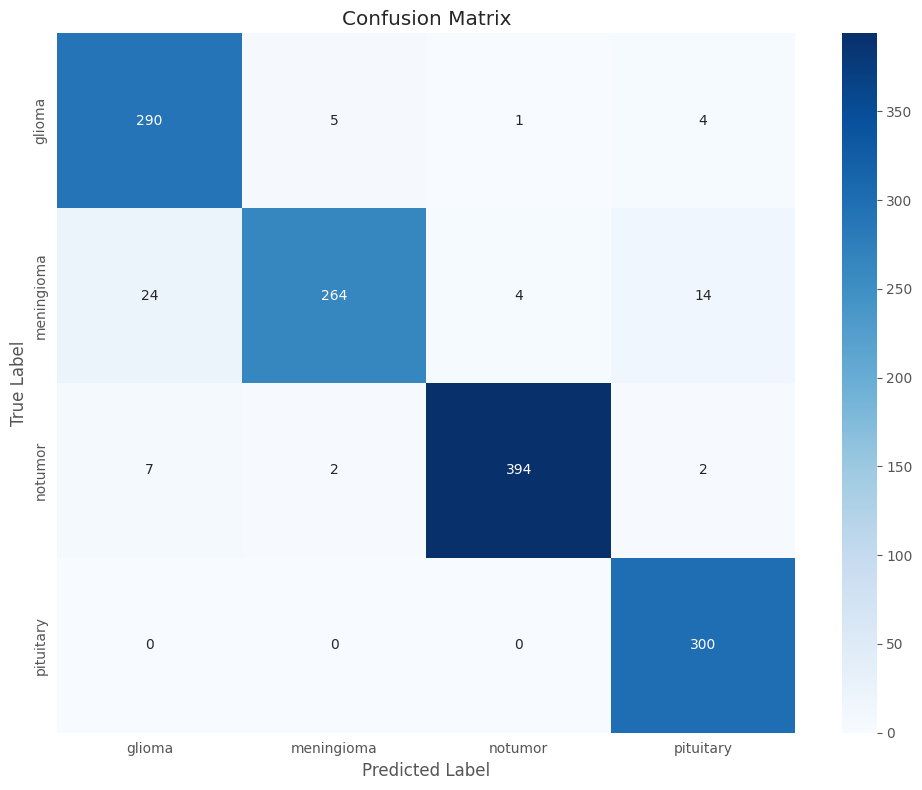

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# If you already have test labels as integers (not one-hot encoded)
y_test_true = y_test  # rename for clarity

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_proba, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,  # replace le.classes_ with your class_names list
    yticklabels=class_names
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [32]:
all_labels_original = data['label'].tolist()  # Get labels from the 'data' DataFrame
class_names = sorted(set(all_labels_original))
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [36]:
from sklearn.metrics import classification_report

# Assuming you have the following already:
# y_test_true: true labels (as integers)
# y_pred: predicted labels (as integers)
# class_names: list of class names (strings)

print("\nClassification Report:")
print(classification_report(y_test_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.90      0.97      0.93       300
  meningioma       0.97      0.86      0.92       306
     notumor       0.99      0.97      0.98       405
   pituitary       0.94      1.00      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



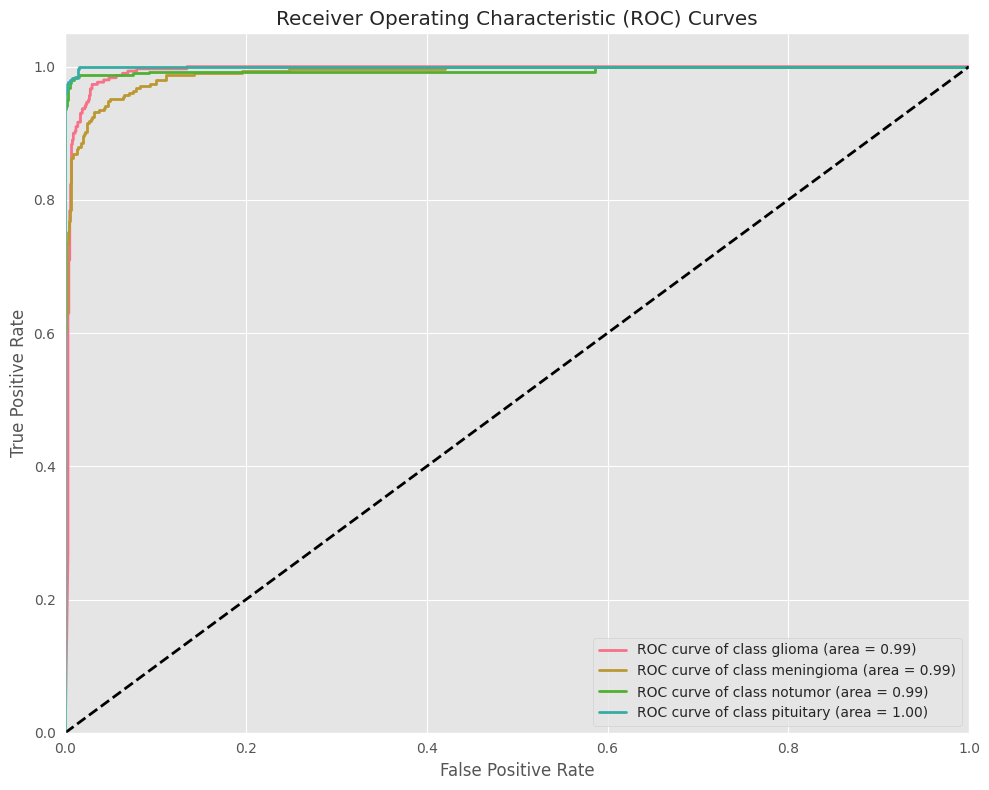

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming:
# - y_test_bin is the one-hot encoded version of your true test labels
# - y_pred_proba is the predicted probabilities from your VGG16 model (via model.predict)
# - class_names is a list of your class names

# Number of classes (same as training)
num_classes = len(class_names)

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random chance)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

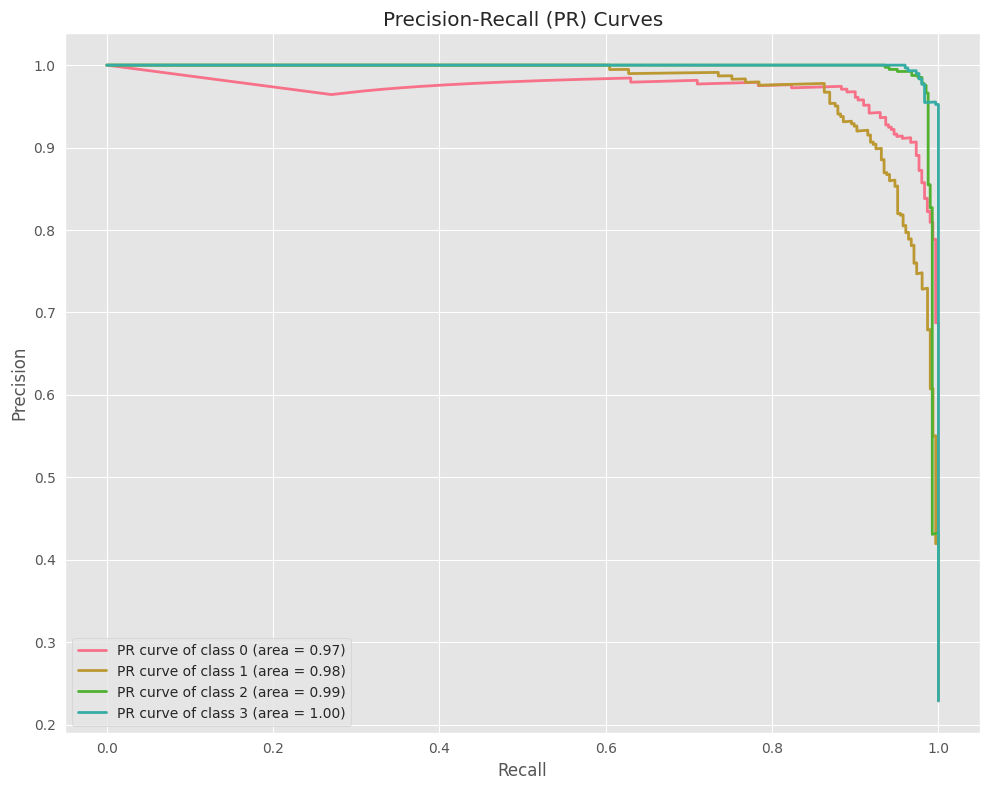

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    pr_auc = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])

    plt.plot(recall, precision, lw=2,
             label=f'PR curve of class {le.classes_[i]} (area = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curves')
plt.legend(loc="best")
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

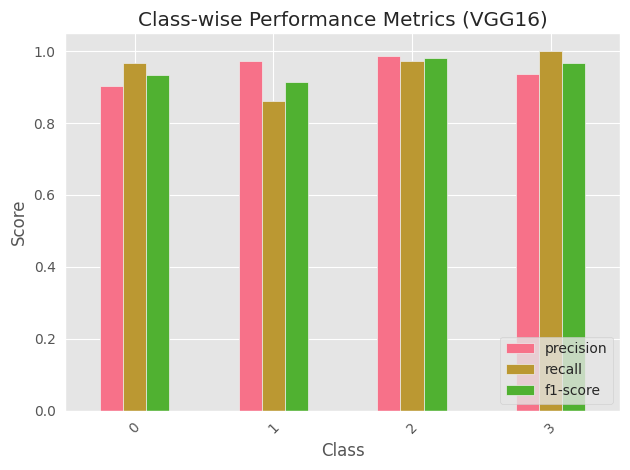

In [39]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Generate classification report as dictionary
class_report = classification_report(y_test_true, y_pred, target_names=le.classes_, output_dict=True)

# Convert to DataFrame and extract precision, recall, f1-score for each class
class_metrics = pd.DataFrame(class_report).transpose().iloc[:num_classes, :3]

# Plot class-wise metrics
plt.figure(figsize=(12, 6))
class_metrics[['precision', 'recall', 'f1-score']].plot(kind='bar')

plt.title('Class-wise Performance Metrics (VGG16)')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(ticks=range(num_classes), labels=le.classes_, rotation=45)
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


check the image


In [42]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt


def preprocess_image(image_path, target_size=(224, 224)):
    """Loads and preprocesses an image for the VGG16 model."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Ensure correct color channel order
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img, axis=0)  # Add batch dimension
    return img_array

def detect_and_display(image_path, model, class_names):
    # Preprocess the image
    img_array = preprocess_image(image_path)

    # Make prediction
    predictions = model.predict(img_array)

    # Get the index of the highest predicted probability
    predicted_index = np.argmax(predictions)
    predicted_class = class_names[predicted_index]
    confidence = predictions[0][predicted_index]

    # Show the image
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Print the predicted class and confidence
    print(f"Predicted tumor type: {predicted_class}")
    print(f"Confidence score: {confidence:.4f}")

# Example usage:
class_names = ['Glioma', 'Meningioma', 'No Tumor','Pituitary']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


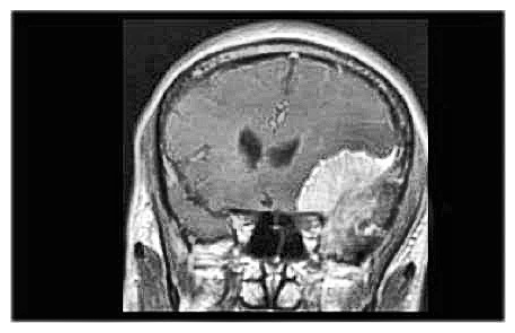

Predicted tumor type: Meningioma
Confidence score: 0.9996


In [43]:
image_path ='/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/classification/Testing/meningioma/enh_Te-meTr_0000.jpg'
detect_and_display(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


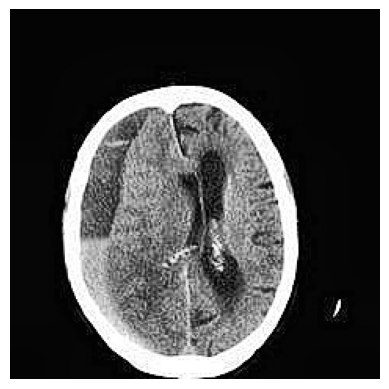

Predicted tumor type: No Tumor
Confidence score: 0.8750


In [44]:
image_path ='/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/classification/Testing/notumor/enh_Te-noTr_0000.jpg'
detect_and_display(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


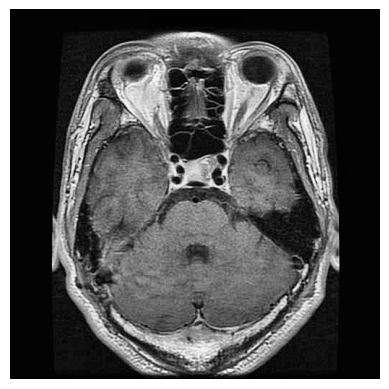

Predicted tumor type: Pituitary
Confidence score: 1.0000


In [45]:
image_path ='/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/classification/Testing/pituitary/enh_Te-piTr_0000.jpg'
detect_and_display(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


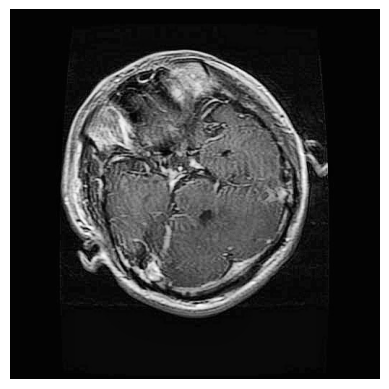

Predicted tumor type: Glioma
Confidence score: 1.0000


In [46]:
image_path ='/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/classification/Testing/glioma/enh_Te-glTr_0006.jpg'
detect_and_display(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


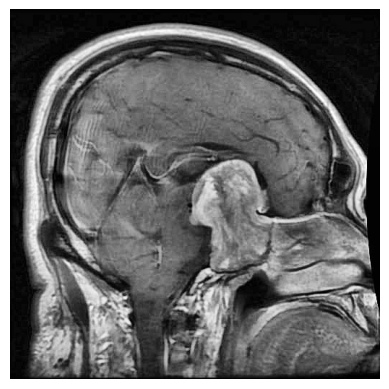

Predicted tumor type: Pituitary
Confidence score: 0.9998


In [49]:
image_path ='/content/drive/MyDrive/brain tumor segmentation and classification/DATASET/classification/Testing/pituitary/enh_Te-pi_0268.jpg'
detect_and_display(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


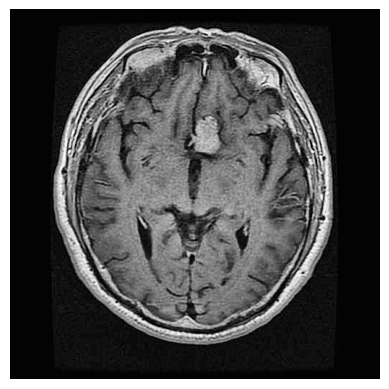

Predicted tumor type: Pituitary
Confidence score: 0.9939


In [50]:
image_path ='/content/enh_Te-pi_0175.jpg'
detect_and_display(image_path, model, class_names)